In [1]:
import time
import numpy as np
import pandas as pd

In [2]:
import tensorflow.python.keras as keras
from tensorflow.python.keras.layers import Layer
import tensorflow as tf
import dan_models
import dan_utils

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
randseed = 25
dan_utils.setup_seed(randseed)
res = 11

v = pd.read_csv('../data/v_20_aggragated.csv')
v = v.rename(columns={'Unnamed: 0': 'id'})
det_with_class = pd.read_csv('../res/%i_res%i_id_402_withclass.csv'%(randseed, res), index_col=0)

v['class_i'] = ''
for i in range(len(v)):
    v.loc[i, 'class_i'] = det_with_class[det_with_class['id']==v.loc[i, 'id']].iloc[0, 5]  # 5 stands for 'class_i'

num_class = det_with_class['class_i'].drop_duplicates().size

v_class = []
for i in range(num_class):
    v_class.append(v[v['class_i']==i])

print('There are %i class(es)'%num_class)

dist_mat = pd.read_csv('../data/dist_mat.csv', index_col=0)
id_info = pd.read_csv('../data/id2000.csv', index_col=0)
dist_mat.index = id_info['id2']
dist_mat.columns = id_info['id2']
for i in range(len(dist_mat)):
    for j in range(len(dist_mat)):
        if i==j:
            dist_mat.iloc[i, j] = 0

near_id = pd.DataFrame(np.argsort(np.array(dist_mat)), index = id_info['id2'], columns = id_info['id2'])

seg = pd.read_csv('../data/segement.csv', header=None)
num_dets = 25

det_list_class = []
for i in range(num_class):
    det_list_class_temp, v_class_temp = dan_utils.get_class_with_node(seg, v_class[i])
    det_list_class.append(det_list_class_temp)
    v_class_temp = v_class_temp[v_class_temp['id'].isin(det_list_class_temp[:num_dets])]
    v_class[i] = v_class_temp
    
near_road_set = []
for i in range(num_class):
    near_road_set.append(dan_utils.rds_mat(dist_mat, det_list_class[i][:num_dets], seg))

There are 5 class(es)


C:\Users\10169\anaconda3\envs\dan_traff\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [5]:
# ind, class
# 0  , blue
# 1  , green
# 2  , yellow  <--
# 3  , black   <--
# 4  , red     <--
class_color_set = ['b', 'g', 'y', 'black', 'r']
class_i = 4

near_road = np.array(near_road_set[class_i])
flow = v_class[class_i].iloc[:, 2:-1]

prop = 3/10  # proportion of training data

k, t_p, t_input, t_pre, num_links = 5, 10, 12, 3, 25
from_day = 21
to_day = 31

image_train, image_test, day_train, day_test, label_train, label_test\
= dan_utils.sliding_window(
    flow, near_road, from_day, to_day, prop, 
    k, t_p, t_input, t_pre, num_links
)

(25, 1584)
(1161, 5, 12, 25)
(348, 5, 12, 25)
(813, 5, 12, 25)
(348, 25, 3)
(813, 25, 3)


In [6]:
input_data = keras.Input(shape=(k,t_input,num_links), name='input_data')
input_HA = keras.Input(shape=(num_links, t_pre), name='input_HA')

finish_model = dan_models.build_model(input_data, input_HA)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data (InputLayer)         [(None, 5, 12, 25)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 5, 12, 25)    100         input_data[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 12, 25)    5650        batch_normalization[0][0]        
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 5, 12, 25)    0           conv2d[0][0]                     
______________________________________________________________________________________________

In [7]:
finish_model.compile(optimizer='adam', loss='mean_squared_error')

In [8]:
X_train = image_train
X_HA_train = day_train
label_train = label_train

In [19]:
#模型拟合与评估
finish_model.fit([X_train,X_HA_train], label_train, epochs=300, batch_size=128,
validation_data=([image_test,day_test], label_test))
# finish_model.evaluate(image_test, label_test)

Epoch 1/300
3/3 [==============================] - 0s 55ms/step - loss: 241.6644 - val_loss: 360.5455
Epoch 2/300
3/3 [==============================] - 0s 27ms/step - loss: 246.2664 - val_loss: 360.7989
Epoch 3/300
3/3 [==============================] - 0s 28ms/step - loss: 241.4834 - val_loss: 356.7527
Epoch 4/300
3/3 [==============================] - 0s 29ms/step - loss: 236.9381 - val_loss: 353.9911
Epoch 5/300
3/3 [==============================] - 0s 26ms/step - loss: 235.8258 - val_loss: 355.6463
Epoch 6/300
3/3 [==============================] - 0s 29ms/step - loss: 234.8730 - val_loss: 356.5104
Epoch 7/300
3/3 [==============================] - 0s 25ms/step - loss: 234.6545 - val_loss: 353.9312
Epoch 8/300
3/3 [==============================] - 0s 29ms/step - loss: 232.4049 - val_loss: 346.1666
Epoch 9/300
3/3 [==============================] - 0s 29ms/step - loss: 232.0633 - val_loss: 345.8500
Epoch 10/300
3/3 [==============================] - 0s 29ms/step - loss: 245.6505 

3/3 [==============================] - 0s 33ms/step - loss: 157.6431 - val_loss: 285.5440
Epoch 81/300
3/3 [==============================] - 0s 32ms/step - loss: 159.7319 - val_loss: 284.5896
Epoch 82/300
3/3 [==============================] - 0s 31ms/step - loss: 158.3250 - val_loss: 284.7578
Epoch 83/300
3/3 [==============================] - 0s 29ms/step - loss: 159.8852 - val_loss: 282.9163
Epoch 84/300
3/3 [==============================] - 0s 27ms/step - loss: 155.3883 - val_loss: 280.2308
Epoch 85/300
3/3 [==============================] - 0s 28ms/step - loss: 155.2887 - val_loss: 281.4774
Epoch 86/300
3/3 [==============================] - 0s 32ms/step - loss: 156.6088 - val_loss: 284.1143
Epoch 87/300
3/3 [==============================] - 0s 32ms/step - loss: 153.1952 - val_loss: 280.8908
Epoch 88/300
3/3 [==============================] - 0s 32ms/step - loss: 156.3704 - val_loss: 276.7972
Epoch 89/300
3/3 [==============================] - 0s 29ms/step - loss: 151.7711 - va

3/3 [==============================] - 0s 33ms/step - loss: 121.3506 - val_loss: 251.2009
Epoch 160/300
3/3 [==============================] - 0s 32ms/step - loss: 120.9869 - val_loss: 254.6742
Epoch 161/300
3/3 [==============================] - 0s 33ms/step - loss: 123.0645 - val_loss: 255.0262
Epoch 162/300
3/3 [==============================] - 0s 31ms/step - loss: 120.9529 - val_loss: 249.7251
Epoch 163/300
3/3 [==============================] - 0s 32ms/step - loss: 119.5226 - val_loss: 248.3147
Epoch 164/300
3/3 [==============================] - 0s 32ms/step - loss: 120.0819 - val_loss: 253.6384
Epoch 165/300
3/3 [==============================] - 0s 32ms/step - loss: 118.9714 - val_loss: 255.1293
Epoch 166/300
3/3 [==============================] - 0s 32ms/step - loss: 117.3734 - val_loss: 248.1061
Epoch 167/300
3/3 [==============================] - 0s 32ms/step - loss: 118.6495 - val_loss: 246.9276
Epoch 168/300
3/3 [==============================] - 0s 32ms/step - loss: 117.

Epoch 238/300
3/3 [==============================] - 0s 29ms/step - loss: 102.8750 - val_loss: 234.1072
Epoch 239/300
3/3 [==============================] - 0s 31ms/step - loss: 105.0889 - val_loss: 235.4188
Epoch 240/300
3/3 [==============================] - 0s 33ms/step - loss: 102.6104 - val_loss: 233.8623
Epoch 241/300
3/3 [==============================] - 0s 30ms/step - loss: 105.5183 - val_loss: 231.8705
Epoch 242/300
3/3 [==============================] - 0s 31ms/step - loss: 102.8619 - val_loss: 236.3669
Epoch 243/300
3/3 [==============================] - 0s 29ms/step - loss: 104.1102 - val_loss: 237.5327
Epoch 244/300
3/3 [==============================] - 0s 30ms/step - loss: 101.6630 - val_loss: 236.1628
Epoch 245/300
3/3 [==============================] - 0s 32ms/step - loss: 101.5543 - val_loss: 235.5452
Epoch 246/300
3/3 [==============================] - 0s 28ms/step - loss: 102.3849 - val_loss: 236.6649
Epoch 247/300
3/3 [==============================] - 0s 31ms/ste

In [20]:
#模型预测
model_pre = finish_model.predict([image_test,day_test])

In [21]:
#计算各项误差指标

mape_mean = dan_utils.mape_loss_func(model_pre, label_test)
smape_mean = dan_utils.smape_loss_func(model_pre, label_test)
mae_mean = dan_utils.mae_loss_func(model_pre, label_test)

print('mape = ' + str(mape_mean) + '\n' + 'smape = ' + str(smape_mean) + '\n' + 'mae = ' + str(mae_mean))

mape = 0.21963382786453045
smape = 0.21209231316038218
mae = 10.696137128729314


In [22]:
#模型保存
finish_model.save_weights('../model/base_ST-DTNN_mape=%.5f.h5'%(mape_mean))


In [23]:
#计算每条路段的误差
mape_list = []
for i in range(num_links):
    a1 = dan_utils.mape_loss_func(model_pre[:,i,:], label_test[:,i,:])
    mape_list.append(a1)
    print(str(i+1)+'th link')
    print(a1)

1th link
0.13701295893469376
2th link
0.1929647164371856
3th link
0.21532404839332261
4th link
0.13338533952901208
5th link
0.2626332998722164
6th link
0.07279716809164638
7th link
0.24409514866593354
8th link
0.15111157546670995
9th link
0.5553538235711406
10th link
0.21649124804532618
11th link
0.4569709115244906
12th link
0.11570100682145694
13th link
0.11038895645615944
14th link
0.7328916478171045
15th link
0.21527812573155686
16th link
0.14248518217356812
17th link
0.2766129433003444
18th link
0.366598467720576
19th link
0.16104914536081558
20th link
0.10643182365520892
21th link
0.1618668606423317
22th link
0.08887446440902824
23th link
0.13574076916731184
24th link
0.12164447357289883
25th link
0.11869110351309989


In [24]:
mape_pd = pd.Series(mape_list)

In [25]:
mape_pd.sort_values()

5     0.072797
21    0.088874
19    0.106432
12    0.110389
11    0.115701
24    0.118691
23    0.121644
3     0.133385
22    0.135741
0     0.137013
15    0.142485
7     0.151112
18    0.161049
20    0.161867
1     0.192965
14    0.215278
2     0.215324
9     0.216491
6     0.244095
4     0.262633
16    0.276613
17    0.366598
10    0.456971
8     0.555354
13    0.732892
dtype: float64

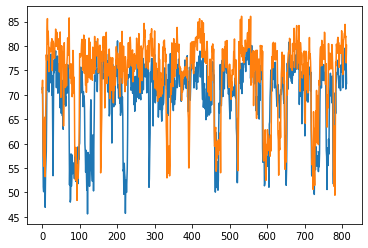

In [26]:
import matplotlib.pyplot as plt

plt.plot(model_pre[:, 0, 0])
plt.plot(label_test[:, 0, 0])

In [27]:
model_pre.shape

(813, 25, 3)